# State-Space Models (SSMs)

A **State-Space Model (SSM)** is a probabilistic model that describes a system evolving over time using latent states.  

It consists of two main equations:

1. **State Transition (Dynamics):**

$$
z_{t} = f_\theta(z_{t-1}, u_{t}) + \epsilon_t, \quad \epsilon_t \sim \mathcal{N}(0, Q)
$$

Where:  
- $z_t$: latent state at time $t$  
- $u_t$: input/control at time $t$  
- $f_\theta$: transition function (linear or nonlinear)  
- $\epsilon_t$: process noise  

2. **Observation Model:**

$$
x_{t} = g_\phi(z_{t}) + \eta_t, \quad \eta_t \sim \mathcal{N}(0, R)
$$

Where:  
- $x_t$: observed data (e.g., MNIST image flattened)  
- $g_\phi$: emission function  
- $\eta_t$: observation noise  

Goal: **Infer latent states $z_t$** from observations $x_t$ and optionally predict future states.


## Derivation of the Log-Likelihood

The likelihood of observations given parameters:

$$
p(x_{1:T} \mid \theta, \phi) = \int p(z_1) \prod_{t=2}^{T} p(z_t \mid z_{t-1}, \theta) \prod_{t=1}^{T} p(x_t \mid z_t, \phi) dz_{1:T}
$$

For **linear Gaussian SSMs**:

$$
z_t \mid z_{t-1} \sim \mathcal{N}(Az_{t-1}, Q), \quad x_t \mid z_t \sim \mathcal{N}(Cz_t, R)
$$

The **log-likelihood** can be approximated using **Kalman filtering**:

$$
\log p(x_{1:T}) = \sum_{t=1}^T \log \mathcal{N}(x_t \mid C\hat{z}_t, S_t)
$$

Where $S_t$ is the predictive covariance.


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# MNIST Dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

# Linear State-Space Model
class LinearSSM(nn.Module):
    def __init__(self, state_dim, obs_dim):
        super().__init__()
        self.A = nn.Parameter(torch.eye(state_dim))      # Transition
        self.C = nn.Parameter(torch.randn(obs_dim, state_dim))  # Emission

    def forward(self, z_prev):
        z = z_prev @ self.A.T
        x_pred = z @ self.C.T
        return z, x_pred

state_dim = 32  # latent dimension
obs_dim = 28*28
ssm = LinearSSM(state_dim, obs_dim).to(device)
optimizer = optim.Adam(ssm.parameters(), lr=0.01)
loss_fn = nn.MSELoss()


100%|██████████| 9.91M/9.91M [00:02<00:00, 4.93MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 130kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.25MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.20MB/s]


## Computation in SSM

1. **Initialization:**  
$$
z_0 = 0
$$

2. **Forward Propagation:**  
- Predict next state: $z_t = z_{t-1} A$
- Predict observation: $\hat{x}_t = z_t C$
- Compute reconstruction loss: $L = \|x_t - \hat{x}_t\|^2$

3. **Backpropagation:**  
- Compute gradients w.r.t. $A$ and $C$
- Update parameters using gradient descent

This is repeated over all batches and epochs.


In [2]:
num_epochs = 50
loss_history = []

for epoch in range(num_epochs):
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.to(device)
        batch_size = x.size(0)
        z = torch.zeros(batch_size, state_dim, device=device)

        # Forward pass through linear SSM
        z, x_pred = ssm(z)

        # Compute MSE loss
        loss = loss_fn(x_pred, x)

        # Backprop and update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_history.append(loss.item())
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


Epoch [1/50], Loss: 0.1130
Epoch [2/50], Loss: 0.1088
Epoch [3/50], Loss: 0.1073
Epoch [4/50], Loss: 0.1204
Epoch [5/50], Loss: 0.1130
Epoch [6/50], Loss: 0.1141
Epoch [7/50], Loss: 0.1155
Epoch [8/50], Loss: 0.1170
Epoch [9/50], Loss: 0.1169
Epoch [10/50], Loss: 0.1131
Epoch [11/50], Loss: 0.1053
Epoch [12/50], Loss: 0.1076
Epoch [13/50], Loss: 0.1131
Epoch [14/50], Loss: 0.1180
Epoch [15/50], Loss: 0.1099
Epoch [16/50], Loss: 0.1102
Epoch [17/50], Loss: 0.1099
Epoch [18/50], Loss: 0.1182
Epoch [19/50], Loss: 0.1130
Epoch [20/50], Loss: 0.1168
Epoch [21/50], Loss: 0.1185
Epoch [22/50], Loss: 0.1130
Epoch [23/50], Loss: 0.1109
Epoch [24/50], Loss: 0.1035
Epoch [25/50], Loss: 0.1122
Epoch [26/50], Loss: 0.1127
Epoch [27/50], Loss: 0.1144
Epoch [28/50], Loss: 0.1109
Epoch [29/50], Loss: 0.1118
Epoch [30/50], Loss: 0.1086
Epoch [31/50], Loss: 0.1145
Epoch [32/50], Loss: 0.1107
Epoch [33/50], Loss: 0.1153
Epoch [34/50], Loss: 0.1112
Epoch [35/50], Loss: 0.1149
Epoch [36/50], Loss: 0.1130
E

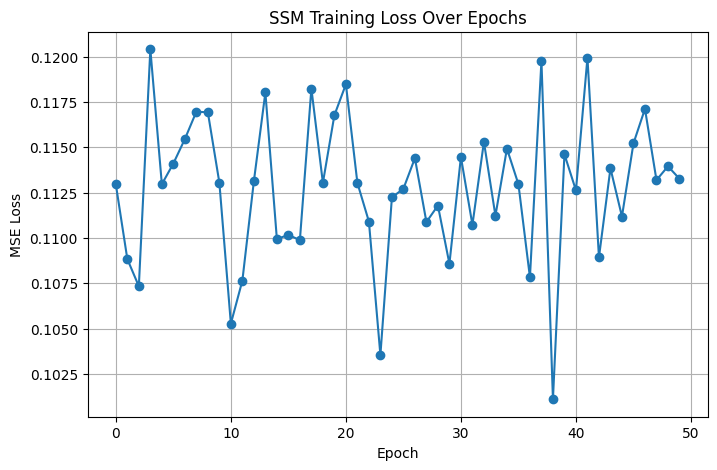

In [3]:
plt.figure(figsize=(8,5))
plt.plot(loss_history, marker='o')
plt.title("SSM Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid()
plt.show()


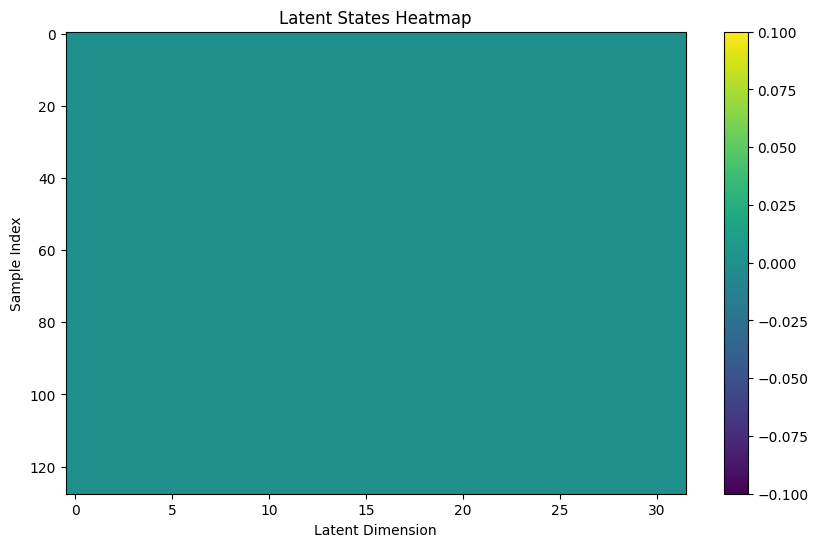

In [4]:
# Sample a batch
x, _ = next(iter(train_loader))
x = x.to(device)
batch_size = x.size(0)
z = torch.zeros(batch_size, state_dim, device=device)
z, x_pred = ssm(z)

plt.figure(figsize=(10,6))
plt.imshow(z.detach().cpu().numpy(), aspect='auto', cmap='viridis')
plt.colorbar()
plt.title("Latent States Heatmap")
plt.xlabel("Latent Dimension")
plt.ylabel("Sample Index")
plt.show()


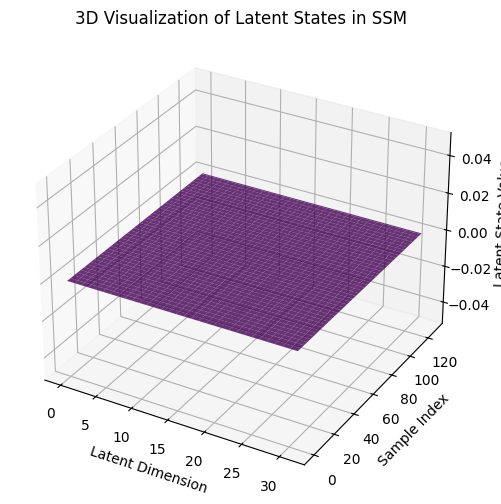

In [5]:
X, Y = np.meshgrid(np.arange(state_dim), np.arange(batch_size))
Z = z.detach().cpu().numpy()

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8)
ax.set_xlabel("Latent Dimension")
ax.set_ylabel("Sample Index")
ax.set_zlabel("Latent State Value")
ax.set_title("3D Visualization of Latent States in SSM")
plt.show()


## Interpretation

1. The SSM learns a **latent representation $z_t$** of MNIST images.
2. 2D heatmaps show how **latent states evolve across samples**.
3. 3D plots provide an intuitive visualization of the **latent state manifold**.

---

## Use Cases

- **Time-series prediction:** Model sequential data using latent dynamics.
- **Generative modeling:** Latent states can be decoded to generate new samples.
- **Reinforcement learning:** SSMs can model environment dynamics for planning.
